**Amazon Stock Forecasting in Pytorch with LSTM**

Source: Youtube - Greg Hogg

Link: https://www.youtube.com/watch?v=q_HS4s1L8UI

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [10]:
data = pd.read_csv('AMZN.csv')

data.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000


In [11]:
data = data[['Date','Close']]
data.head(3)

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417


In [12]:
device = 'cuda:0'

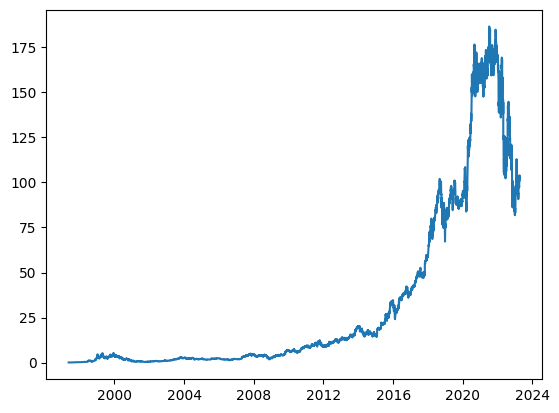

In [13]:
data.loc[:,'Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'],data['Close'])
plt.show()

In [14]:
data['Date']

0       1997-05-15 00:00:00
1       1997-05-16 00:00:00
2       1997-05-19 00:00:00
3       1997-05-20 00:00:00
4       1997-05-21 00:00:00
               ...         
6511    2023-03-30 00:00:00
6512    2023-03-31 00:00:00
6513    2023-04-03 00:00:00
6514    2023-04-04 00:00:00
6515    2023-04-05 00:00:00
Name: Date, Length: 6516, dtype: object

In [90]:
from copy import deepcopy as dc 

seq_length = 7
df = dc(data)
df.set_index('Date',inplace = True)

for i in range(1,seq_length+1):
    df[f'Close(t-{i})'] = df['Close'].shift(i)

df.dropna(inplace=True)

df.head(3)

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417


In [91]:
df = df.to_numpy()

df

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

In [92]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
df = scaler.fit_transform(df)
df


array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [163]:
X = df[:,1:]
X = dc(np.flip(X,axis=1))

y = df[:,0]
X.shape,y.shape

((6509, 7), (6509,))

In [146]:
# split_index = int(len(X)*0.95)

# X_train = torch.tensor(X[:split_index],dtype = torch.float64)
# X_test = torch.tensor(X[split_index:],dtype = torch.float64)
# y_train = torch.tensor(y[:split_index],dtype = torch.float64)
# y_test = torch.tensor(y[split_index:],dtype = torch.float64)

# X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 7]),
 torch.Size([326, 7]),
 torch.Size([6183]),
 torch.Size([326]))

In [ ]:
#from numpy
split_index = int(len(X)*0.95)

X_train = torch.from_numpy(X[:split_index]).float()
X_test = torch.from_numpy(X[split_index:]).float()
y_train = torch.from_numpy(y[:split_index]).float()
y_test = torch.from_numpy(y[split_index:]).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [170]:
X_train = X_train.reshape((-1,seq_length,1))
X_test = X_test.reshape((-1,seq_length,1))
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 7, 1]),
 torch.Size([326, 7, 1]),
 torch.Size([6183, 1]),
 torch.Size([326, 1]))

In [171]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y 

    def __len__(self):
        return len(self.X)
    def __getitem__(self,i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train,y_train)
test_dataset = TimeSeriesDataset(X_test,y_test)

In [172]:
train_dataset.__getitem__(1000)

(tensor([[-0.9918],
         [-0.9913],
         [-0.9917],
         [-0.9921],
         [-0.9927],
         [-0.9929],
         [-0.9929]]),
 tensor([-0.9936]))

In [173]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [174]:
for _,batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape,y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [181]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers):
        super(LSTM,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size,num_layers,batch_first = True)
        
        self.fc = nn.Linear(hidden_size,1)
        
    def forward(self,X):
        batch_size = X.size(0)
        
        h0 = torch.zeros(self.num_layers,batch_size,self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers,batch_size,self.hidden_size).to(device)

        out,_ = self.lstm(X,(h0,c0))
        out = self.fc(out[:,-1,:])
        
        return out

In [197]:
model = LSTM(1,4,1).to(device)

learning_rate = 0.001
num_epochs = 10
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    for i, (x_batch,y_batch) in enumerate(train_loader):

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        output = model(x_batch)

        loss = criterion(output,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0: 
            print(f'Epoch [{epoch+1}/{num_epochs}],step {i}/{n_total_steps}, loss = {loss:.4f}')        

Epoch [1/10],step 0/387, loss = 0.2488
Epoch [1/10],step 100/387, loss = 0.1338
Epoch [1/10],step 200/387, loss = 0.1901
Epoch [1/10],step 300/387, loss = 0.0016
Epoch [2/10],step 0/387, loss = 0.0124
Epoch [2/10],step 100/387, loss = 0.0017
Epoch [2/10],step 200/387, loss = 0.0012
Epoch [2/10],step 300/387, loss = 0.0007
Epoch [3/10],step 0/387, loss = 0.0003
Epoch [3/10],step 100/387, loss = 0.0006
Epoch [3/10],step 200/387, loss = 0.0005
Epoch [3/10],step 300/387, loss = 0.0007
Epoch [4/10],step 0/387, loss = 0.0003
Epoch [4/10],step 100/387, loss = 0.0002
Epoch [4/10],step 200/387, loss = 0.0002
Epoch [4/10],step 300/387, loss = 0.0001
Epoch [5/10],step 0/387, loss = 0.0004
Epoch [5/10],step 100/387, loss = 0.0005
Epoch [5/10],step 200/387, loss = 0.0004
Epoch [5/10],step 300/387, loss = 0.0001
Epoch [6/10],step 0/387, loss = 0.0001
Epoch [6/10],step 100/387, loss = 0.0003
Epoch [6/10],step 200/387, loss = 0.0001
Epoch [6/10],step 300/387, loss = 0.0007
Epoch [7/10],step 0/387, los

In [198]:
# running_loss = 0
# with torch.no_grad():
#     for i, (x_batch,y_batch) in enumerate(test_loader): 
#         x_batch,y_batch = x_batch.to(device), y_batch.to(device)
    
#     output = model(x_batch)
#     loss = criterion(output,y_batch)
#     running_loss += loss

# avg_loss_across_batches = running_loss / len(test_loader)

# print(f'Val Loss: {avg_loss_across_batches:.3f}')



Val Loss: 0.000


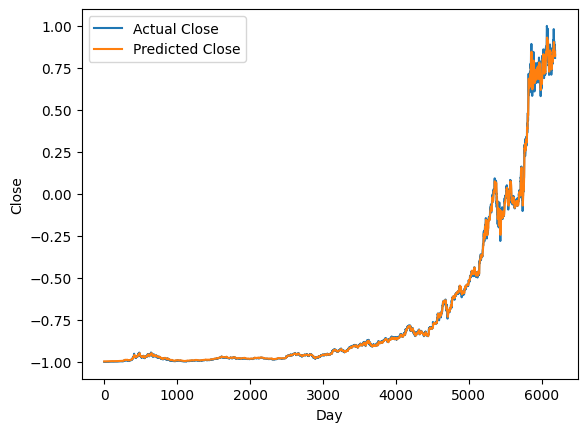

In [199]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train,label = 'Actual Close')
plt.plot(predicted, label = 'Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [204]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

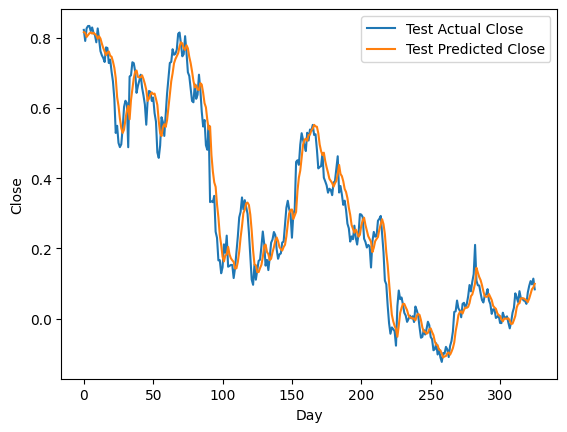

In [205]:
plt.plot(y_test,label = 'Test Actual Close')
plt.plot(test_predictions, label = 'Test Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()